In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [4]:
# Constants
TRAIN_PATH = './data/chest_xray_processed/train'
VALID_PATH = './data/chest_xray_processed/val'
TEST_PATH = './data/chest_xray_processed/test'
CLASSES = ['NORMAL', 'PNEUMONIA']

In [5]:
# Functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(
    TRAIN_PATH, target_size=(224,224), classes=CLASSES, batch_size=100)
valid_batches = ImageDataGenerator().flow_from_directory(
    VALID_PATH, target_size=(224,224), classes=CLASSES, batch_size=100)
test_batches = ImageDataGenerator().flow_from_directory(
    TEST_PATH, target_size=(224,224), classes=CLASSES, batch_size=100)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# Get the pre-trained model
VGG19_Model = VGG19()
VGG19_Model.summary()

In [9]:
# Create a new sequential model
model = Sequential()

# Add VGG19 Layers (except the ouput layer) as non-trainable layers
for i, layer in enumerate((VGG19_Model.layers)[:-1]):
    layer.trainable = False
    model.add(layer)

# Add additional layer(s)
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
# Fit the model on the training data
model.fit_generator(train_batches, steps_per_epoch=500, 
                    validation_data=valid_batches, validation_steps=5, epochs=10, verbose=1)

Epoch 1/10
500/500 [==============================] - 217s 435ms/step - loss: 0.3450 - acc: 0.8283 - val_loss: 0.3584 - val_acc: 0.8750
Epoch 2/10
500/500 [==============================] - 212s 423ms/step - loss: 0.2216 - acc: 0.9207 - val_loss: 0.4423 - val_acc: 0.9375
Epoch 3/10
500/500 [==============================] - 211s 423ms/step - loss: 0.1716 - acc: 0.9436 - val_loss: 0.1630 - val_acc: 0.9375
Epoch 4/10
500/500 [==============================] - 212s 423ms/step - loss: 0.1358 - acc: 0.9561 - val_loss: 0.1136 - val_acc: 1.0000
Epoch 5/10
500/500 [==============================] - 211s 423ms/step - loss: 0.1241 - acc: 0.9601 - val_loss: 0.3526 - val_acc: 0.9375
Epoch 6/10
500/500 [==============================] - 212s 425ms/step - loss: 0.1242 - acc: 0.9595 - val_loss: 0.2403 - val_acc: 0.8750
Epoch 7/10
500/500 [==============================] - 211s 423ms/step - loss: 0.1064 - acc: 0.9661 - val_loss: 0.0712 - val_acc: 1.0000
Epoch 8/10
500/500 [============================

In [12]:
# Test Loss
_, test_labels = next(test_batches) 
test_labels = test_labels[:,0]

predictions = model.predict_generator(test_batches, steps=1, verbose=1)

1/1 [==============================] - 1s 576ms/step


Confusion matrix, without normalization
[[54  9]
 [30  7]]


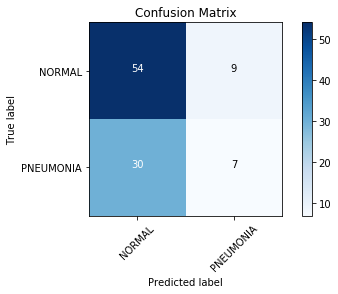

In [13]:
# Plot a Confusion Matrix for the Test Data
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
plot_confusion_matrix(cm, CLASSES, title="Confusion Matrix")